# Exercise Sheet 3


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn as skl
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

### Clustering

We are using again the MNIST data from Exercise 3. The following should just access the data
you have already downloaded (adjust the data_home path!):

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784', data_home='/home/jaeger/Data')

**Exercise 4:** We are exploring several clustering techniques with the MNIST data.

**a** Perform *k*-means clustering with *k*=10 on this dataset. 
<ul>Using visualization techniques analogous to what we have done in the `Clustering` notebook for the faces data, can you determine the 'nature' of the 10 constructed clusters? Do the clusters (roughly) coincide with the 10 different actual digits? </ul>
<ul>Perform a supervised clustering evaluation using adjusted rand index. </ul>
<ul>Are the clustering results stable, when you perform several random restarts of *k*-means? You can use the rand index also for this: take the cluster labels produced by two runs of *k*-means as the input for the rand index. The rand index then measures how much the two clusterings coincide. </ul>

**b** Now perform hierarchical clustering on the data (in order to improve visibility in the constructed dendrograms, you can also use a much reduced dataset as constructed using `sklearn.utils.resample` shown below). Does the visual analysis of the dendrogram indicate a natural number of clusters? Using different cluster distance metrics (ward,single,average), what do the clusterings look like that are producec at the level of *k*=10 clusters? See the `Clustering` notebook for the needed Python code, including the `fcluster` method to retrieve 'plain' clusterings from the hierarchical clustering. 

Some investigations may be easier to perform (and results easier interpreted) if you use a smaller subset of the MNIST data. The following code shows how one can use the skl.utils.resample method for this:

In [44]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split

# Load MNIST data from OpenML
print("Fetching MNIST data...")
mnist = fetch_openml('mnist_784', version=1)
print("Data fetched")

X, y = mnist.data, mnist.target.astype(int)  # Load features and integer labels

# Normalize pixel values
X = X / 255.0

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Perform KMeans clustering with k=10
print("Building and fitting KMeans model...")
k = 10  # Number of clusters (digits 0-9)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_train)

# Assign clusters for training data
train_clusters = kmeans.predict(X_train)

# Map each cluster to the most common actual digit for training data
cluster_labels = np.zeros(k)
for i in range(k):
    mask = (train_clusters == i)
    cluster_labels[i] = mode(y_train[mask])[0]

# Predict on training and test data
train_predicted_labels = np.array([cluster_labels[cluster] for cluster in train_clusters])
test_clusters = kmeans.predict(X_test)
test_predicted_labels = np.array([cluster_labels[cluster] for cluster in test_clusters])

# Evaluate clustering using Adjusted Rand Index (ARI) and Accuracy
train_ari_score = adjusted_rand_score(y_train, train_clusters)
train_accuracy = accuracy_score(y_train, train_predicted_labels)

test_ari_score = adjusted_rand_score(y_test, test_clusters)
test_accuracy = accuracy_score(y_test, test_predicted_labels)

# Output the results
print(f"Training Adjusted Rand Index (ARI): {train_ari_score:.4f}")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Adjusted Rand Index (ARI): {test_ari_score:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Fetching MNIST data...
Data fetched
Building and fitting KMeans model...
Training Adjusted Rand Index (ARI): 0.3626
Training Accuracy: 58.38%
Test Adjusted Rand Index (ARI): 0.3641
Test Accuracy: 58.39%


The KMeans produces a clustering in 10 clusters. THe accuracy is 58% on both the training and test set.

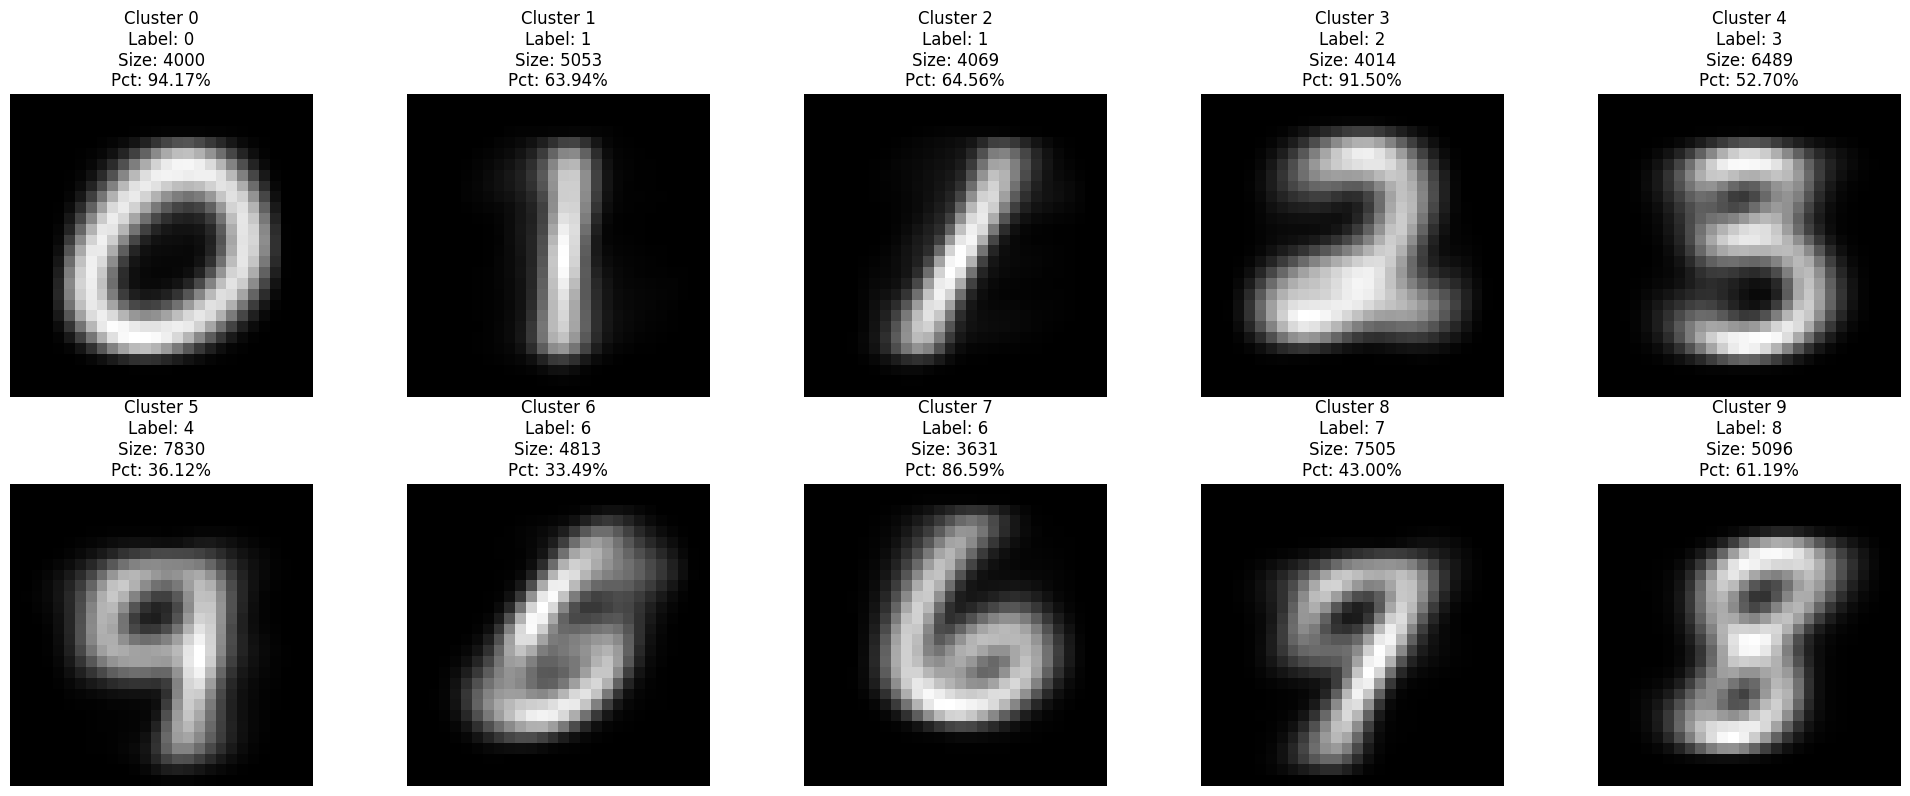

In [46]:
import matplotlib.pyplot as plt

# Calculate cluster percentages
cluster_percentages = np.zeros(k)
for i in range(k):
    mask = (train_clusters == i)
    cluster_percentages[i] = (np.sum(y_train[mask] == cluster_labels[i]) / np.sum(mask)) * 100

# Order clusters by the most common label
order = np.argsort(cluster_labels)
ordered_centroids = kmeans.cluster_centers_[order]
ordered_labels = cluster_labels[order]
ordered_percentages = cluster_percentages[order]

# Visualize ordered cluster centroids
rows = int(k / 5)
fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
for ax, cc, label, pct, i in zip(axes.ravel(), ordered_centroids, ordered_labels, ordered_percentages, range(k)):
    cluster_size = len(np.where(train_clusters == order[i])[0])
    ax.set_title(f"Cluster {i}\nLabel: {int(label)}\nSize: {cluster_size}\nPct: {pct:.2f}%")
    ax.imshow(cc.reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


The visualization of the clusters show the cluster number (0-9), the size of the cluster, the label of the cluster and how many of the samples that align to the label as well as a picture of a sample. 

For clusters 0, 1 and 6 the picture and the label aligns to the cluster number. They do not however have an above average accuracy. Clusters 0, 1, 3, 4, 6, 7, and 9 the label and the pictures do align but the accuracy varies.

Perhaps more interestingly clusters 0, 1, 3, 7 and 9 all has an accuracy above 60% (and thereby above average) and the label and picture aligns.

In [ ]:
small_mnist_data,small_mnist_label = skl.utils.resample(mnist.data,mnist.target,n_samples=200,replace=False)

### Text data

We first use the dataset containing movie reviews from the *Internet Movie Database*. For this, the data first needs to be downloaded from <a href="http://ai.stanford.edu/~amaas/data/sentiment/"> here </a>. Note: this is about 220 Mb.  After uncompressing, the data is contained in a directory `aclImdb` with sub-directories `train` and `test`. In the following, replace the piece of the path that leads to the directory in which you have unpacked the data.

In [4]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [ ]:
reviews_train=load_files(r'C:\Users\KennethElong(KEEL)\Downloads\aclImdb_v1\aclImdb\train',categories=['neg','pos'])
reviews_test=load_files(r'C:\Users\KennethElong(KEEL)\Downloads\aclImdb_v1\aclImdb\test',categories=['neg','pos'])

The following is the same code as in the `TextData` notebook for transforming the data into term-frequency, and term-frequency-inverse-document-frequency vectors. 

In [19]:
## Splitting the training data into a training and validation set with 20% set aside for validation
X_train, X_val, y_train, y_val = train_test_split(
    reviews_train.data, reviews_train.target, test_size=0.2, random_state=11
)

# Vectorize the data
dictionary = CountVectorizer(min_df=0.0005, max_df=0.5).fit(X_train)

# Transform training, validation, and test data to TF-IDF
# Training data
reviews_train_tf_vec = dictionary.transform(X_train)
reviews_train_tfidf_vec = TfidfTransformer().fit_transform(reviews_train_tf_vec)

# Validation data
reviews_val_tf_vec = dictionary.transform(X_val)
reviews_val_tfidf_vec = TfidfTransformer().fit_transform(reviews_val_tf_vec)

# Test data
reviews_test_tf_vec = dictionary.transform(reviews_test.data)
reviews_test_tfidf_vec = TfidfTransformer().fit_transform(reviews_test_tf_vec)

**Exercise 5:** 

Learn at least 2 different kinds of classifiers (k-NN, Naive Bayes, Decision Tree, SVM, Neural Network) for predicting the 'positive' reviews based on the tf or tf-idf vectors. Using a validation set, optimize the classifiers via the available regularization parameters so that overfitting is minimized.  Evaluate the learned classifiers using accuracy, precision, recall, and their ROC curves. 


In [ ]:
## Printing the words at position 6951 to 6956
print(dictionary.get_feature_names_out()[6951:6956])

## This output now is not as it was in the TextData exercise, because the data used to build the dictionary was different seeing as the training set was further divided into a validation and training set.


['heralded' 'herbert' 'hercules' 'herd' 'here']


Training a Naive Bayes model as the first one.

In [25]:
## Training the model
mnb=MultinomialNB().fit(reviews_train_tf_vec,y_train)

# Evaluate on the validation set
val_predictions = mnb.predict(reviews_val_tf_vec)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy: {:.4f}".format(val_accuracy))
#print("\nValidation Classification Report:\n", classification_report(y_val, val_predictions))

# Evaluate on the test set
test_predictions = mnb.predict(reviews_test_tf_vec)
test_accuracy = accuracy_score(reviews_test.target, test_predictions)
print("Test Accuracy: {:.4f}".format(test_accuracy))
#print("\nTest Classification Report:\n", classification_report(reviews_test.target, test_predictions))

Validation Accuracy: 0.8404
Test Accuracy: 0.8256


The Naive Bayers model predict 82.56% on the test data and 84,04% on the validation data. This seems like a fine balance between prediction on the validation and test set.

Opportunities to further enhance the model
- Remove stop words such as "the", "is" and "and"
- Experiment with the min_df and max_df to include or exclude more word at each end of the spectrum
- Adjust the alpha value, default set to 1, to see if this changes the outcome

Training a Support Vector Machine (SVM) model as the second model.

In [28]:
# Train the SVM with linear kernel
svc = SVC(kernel='linear')
svc.fit(reviews_train_tf_vec, y_train)

# Evaluate on the validation set
val_predictions = svc.predict(reviews_val_tf_vec)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy: {:.4f}".format(val_accuracy))
#print("\nValidation Classification Report:\n", classification_report(y_val, val_predictions))

# Evaluate on the test set
test_predictions = svc.predict(reviews_test_tf_vec)
test_accuracy = accuracy_score(reviews_test.target, test_predictions)
print("Test Accuracy: {:.4f}".format(test_accuracy))
#print("\nTest Classification Report:\n", classification_report(reviews_test.target, test_predictions))


Validation Accuracy: 0.8468
Test Accuracy: 0.8299


The SVC model with a linear kernel and default settings get a 84.7% accuracy on the validation and 83% on the test set. It took 18 min compared to training the Naive Bayers model which took only a few seconds. 